<a href="https://colab.research.google.com/github/Faizan-Siddique/Covid-19-and-Pneumonia-Detector/blob/main/Covid_19_and_Pneumonia_X_Ray_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK #1: UNDERSTAND THE PROBLEM STATEMENT AND BUSINESS CASE


<table>
  <tr><td>
    <img src="https://drive.google.com/uc?id=15eGnAbma5Q_j9CZZKi46Gh3-EpgSWYOV"
         alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1. Classifying disease using Deep Learning 
  </td></tr>
</table>


![alt text](https://drive.google.com/uc?id=19BuQ5m0xZWC7vQN4jX9lukmJ4aE0EkL8)

![alt text](https://drive.google.com/uc?id=10tbeSkGZ0xdHtqTGhYwHhb9PPURw0BfD)

# TASK #2: IMPORT LIBRARIES AND DATASET

In [1]:
# This is a custom dataset that contains covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray iamges and normal person x-ray images.
# Each class contains 133 images.
# Dataset Source:
# https://github.com/ieee8023/covid-chestxray-dataset 
# https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:
# You will need to mount your drive using the following commands:
# For more information regarding mounting, please check this out: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Specify training data directory
X_Ray_Directory = '/content/drive/MyDrive/Operations Department/Dataset'

In [4]:
# List the folders in the directory
os.listdir(X_Ray_Directory)

['0', '1', '2', '3']

In [5]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale=1./255,validation_split=0.20)

In [6]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size=40,directory=X_Ray_Directory,target_size=(256,256),shuffle=True,class_mode='categorical',subset='training')

Found 428 images belonging to 4 classes.


In [7]:
validation_generator = image_generator.flow_from_directory(batch_size=40,directory=X_Ray_Directory,target_size=(256,256),shuffle=True,class_mode='categorical',subset='validation')

Found 104 images belonging to 4 classes.


In [8]:
# Generate a batch of 40 images and labels
train_images,train_labels = next(train_generator)

In [9]:
train_images.shape

(40, 256, 256, 3)

In [10]:
train_labels.shape

(40, 4)

In [11]:
train_labels

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]],

In [12]:
# labels Translator 
label_names = { 0:'Covid-19',1:'Normal',2:'Viral Pneumonia',3:'Bacterial Pneumonia'}

# TASK #3: VISUALIZE DATASET

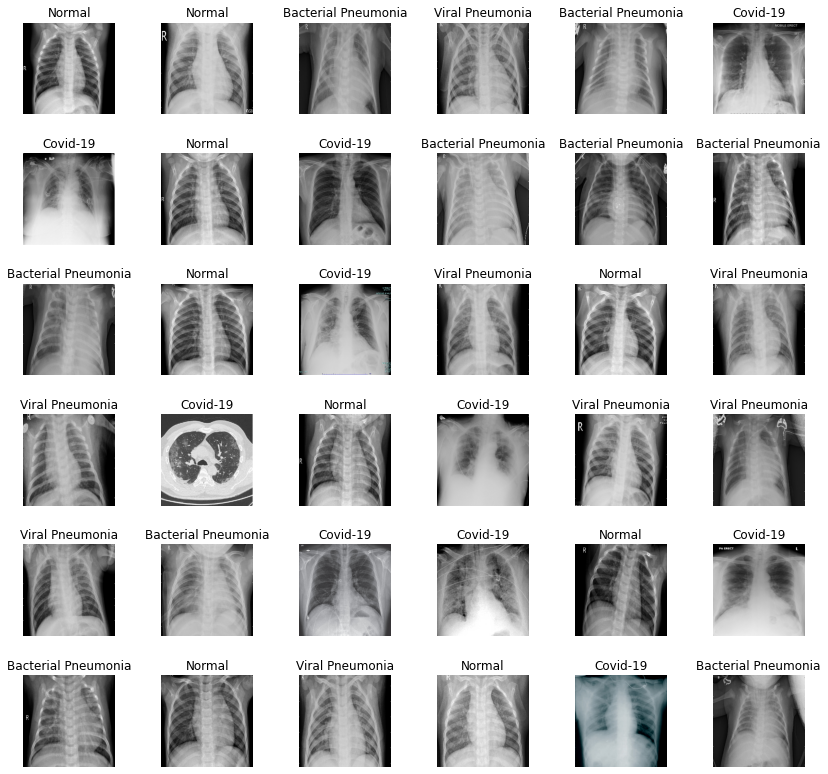

In [13]:
L = 6
W = 6
fig,axes = plt.subplots(L,W,figsize = (14,14) )
axes = axes.ravel() # Flatten the axes

for i in np.arange(0,L*W):
  axes[i].imshow(train_images[i])
  axes[i].set_title(label_names[np.argmax(train_labels[i])])
  axes[i].axis('off')

plt.subplots_adjust(wspace= 0.5)

# TASK #6: IMPORT MODEL WITH PRETRAINED WEIGHTS

In [14]:
basemodel = ResNet50(weights = 'imagenet',include_top = False, input_tensor = Input(shape = (256,256,3)))


In [15]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [16]:
# freezing layers in the model
for layer in basemodel.layers[:-10]:
  layers.trainable = False



# TASK #7: BUILD AND TRAIN DEEP LEARNING MODEL

In [17]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)


In [18]:
model = Model(inputs=basemodel.input,outputs=headmodel)

In [19]:
model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr = 1e-4, decay = 1e-6),metrics='accuracy')


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [20]:
# using early stopping to exit training if validation loss is not decreasing after certain number of epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss',mode='min',patience= 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath='weights.hdf5',verbose=1,save_best_only=True)


In [21]:
train_generator = image_generator.flow_from_directory(batch_size=4,directory=X_Ray_Directory,shuffle=True,target_size=(256,256),class_mode='categorical',subset='training')
valid_generator = image_generator.flow_from_directory(batch_size=4,directory=X_Ray_Directory,shuffle=True,target_size=(256,256),class_mode='categorical',subset='validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [22]:
history = model.fit(train_generator,epochs=25,validation_data=valid_generator,callbacks=[checkpointer,earlystopping]) 

Epoch 1/25
107/107 [==============================] - 46s 282ms/step - loss: 0.8928 - accuracy: 0.7056 - val_loss: 16.3049 - val_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 16.30492, saving model to weights.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
107/107 [==============================] - 29s 270ms/step - loss: 0.5271 - accuracy: 0.8364 - val_loss: 23.1416 - val_accuracy: 0.2500

Epoch 00002: val_loss did not improve from 16.30492
Epoch 3/25
107/107 [==============================] - 29s 270ms/step - loss: 0.3081 - accuracy: 0.8855 - val_loss: 15.1116 - val_accuracy: 0.2500

Epoch 00003: val_loss improved from 16.30492 to 15.11157, saving model to weights.hdf5
Epoch 4/25
107/107 [==============================] - 30s 273ms/step - loss: 0.3435 - accuracy: 0.9182 - val_loss: 7.3332 - val_accuracy: 0.2500

Epoch 00004: val_loss improved from 15.11157 to 7.33320, saving model to weights.hdf5
Epoch 5/25
107/107 [==============================] - 29s 272ms/step - loss: 0.2052 - accuracy: 0.9463 - val_loss: 20.7284 - val_accuracy: 0.2500

Epoch 00005: val_loss did not improve from 7.33320
Epoch 6/25
107/107 [==============================] - 29s 271ms/step - loss: 0.1188 - accuracy: 0.9603 - val_loss: 153.3761 - val_accurac

# TASK #8: EVALUATE TRAINED DEEP LEARNING MODEL

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0, 0.5, 'training accuracy and loss')

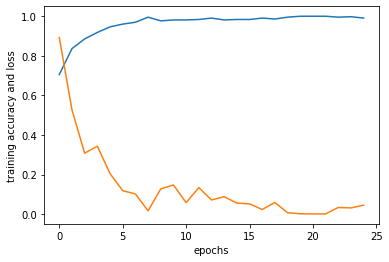

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('training accuracy and loss')


Text(0, 0.5, 'validation loss ')

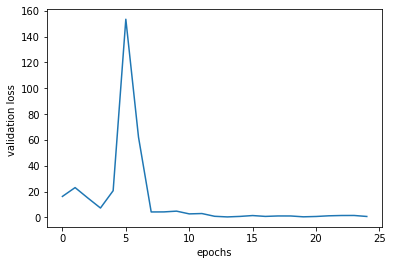

In [25]:
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('validation loss ')

Text(0, 0.5, 'validation accuracy ')

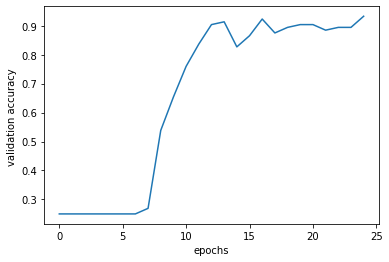

In [26]:
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('validation accuracy ')

In [27]:
test_directory = '/content/drive/MyDrive/Operations Department/Test'

In [28]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size=40,directory=test_directory,target_size=(256,256),shuffle=True,class_mode='categorical')
evaluate = model.evaluate(test_generator,steps=test_generator.n // 4 ,verbose =1)
print('Accuracy test : {}',format(evaluate[1]))

Found 40 images belonging to 4 classes.
10/10 [==============================] - 3s 2ms/step - loss: 2.6586 - accuracy: 0.8000
Accuracy test : {} 0.800000011920929


In [29]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [30]:
len(original)

40

In [31]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.8


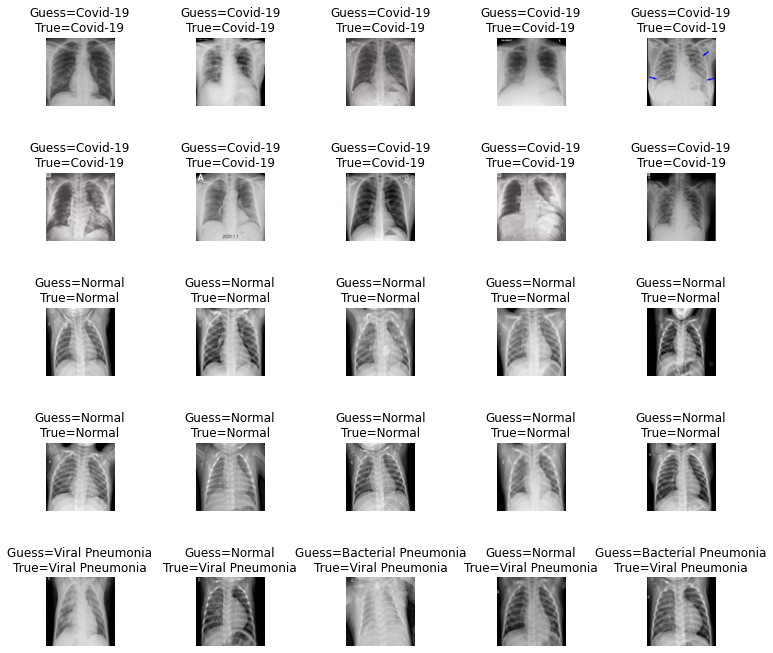

In [32]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [33]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.67      1.00      0.80        10
           2       1.00      0.50      0.67        10
           3       0.78      0.70      0.74        10

    accuracy                           0.80        40
   macro avg       0.84      0.80      0.79        40
weighted avg       0.84      0.80      0.79        40



Text(0.5, 1.0, 'Confusion_matrix')

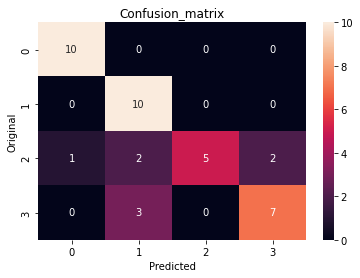

In [34]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')